In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
from datetime import timedelta
sns.set()
import warnings
import math
warnings.filterwarnings('ignore')
tf.set_random_seed(111)

In [2]:
df = pd.read_csv('../dataset/Qingdao_SH.csv')
df.head()

,trade_date,open,high,low,close,pre_close,vol
0,20200303,43.88,43.93,43.06,43.20,43.30,90621.26
1,20200302,42.60,43.95,42.60,43.30,42.70,110009.08
2,20200228,43.04,43.38,42.06,42.70,43.74,143272.44
3,20200227,43.37,44.15,43.25,43.74,43.02,71860.09
4,20200226,43.86,44.79,43.00,43.02,44.24,129634.10


In [3]:
def time2stamp(cmnttime):   #转时间戳函数
    cmnttime=str(cmnttime)
    cmnttime=datetime.strptime(cmnttime,'%Y%m%d')
    return cmnttime
df['trade_date']=df['trade_date'].apply(time2stamp)
df=df.sort_values(by='trade_date')
df.reset_index(inplace=True,drop=True)
date_ori = pd.to_datetime(df.iloc[:, 0]).tolist()

In [26]:
history_date=np.arange('1999-02-01','2020-03-04',dtype='datetime64[D]')
history_date

array(['1999-02-01', '1999-02-02', '1999-02-03', ..., '2020-03-01',
       '2020-03-02', '2020-03-03'], dtype='datetime64[D]')

In [4]:
minmax = MinMaxScaler().fit(df.iloc[:, 1:].astype('float32'))
df_log = minmax.transform(df.iloc[:, 1:].astype('float32'))
df_log = pd.DataFrame(df_log)
df_log.head()

,0,1,2,3,4,5
0,0.004378,0.002736,0.003375,0.004027,0.005177,0.004681
1,0.004569,0.002007,0.003375,0.003452,0.004027,0.002724
2,0.003617,0.000912,0.002978,0.003068,0.003452,0.002028
3,0.001904,0.000000,0.001985,0.002493,0.003068,0.005082
4,0.002284,0.000182,0.002184,0.002301,0.002493,0.003575


In [5]:
df_log.shape

(5000, 6)

In [6]:
num_layers = 1
size_layer = 128
timestamp = 14
epoch = 100
dropout_rate = 0.7
future_day = 60

In [7]:
class Model:
    def __init__(
        self,
        learning_rate,
        num_layers,
        size,
        size_layer,
        output_size,
        forget_bias = 0.1,
        attention_size = 10,
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)
        
        with tf.name_scope('LSTM_layer'):
            rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
                [lstm_cell(size_layer) for _ in range(num_layers)],state_is_tuple = False,)
            
            self.X = tf.placeholder(tf.float32, (None, None, size),name='input_x')  # (win,1,features)
            self.Y = tf.placeholder(tf.float32, (None, output_size),name='input_y') # (win,features)
            
            with tf.name_scope('Dropout_layer'):
                drop = tf.contrib.rnn.DropoutWrapper(rnn_cells, output_keep_prob = forget_bias)

            self.hidden_layer = tf.placeholder(
                tf.float32, (None, num_layers * 2 * size_layer),name='rnn_init')
            
            self.outputs, self.last_state = tf.nn.dynamic_rnn(
                drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32)  
            
            # output: [batch_size, window_size, units] 没有attention的话，往后传的是output
            # state: [batch_size,units]   作为attention
        with tf.name_scope('attention_layer'):
            attention_w = tf.get_variable('attention_w', [attention_size], tf.float32) # （10，） values
            print('attention_w: ',attention_w.shape)
            
            with tf.name_scope('query_dense'):
                query = tf.layers.dense(tf.expand_dims(self.last_state[:, size_layer:], 1), attention_size)
                print('query: ',query.shape)
            
            with tf.name_scope('keys_dense'):
                keys = tf.layers.dense(self.outputs, attention_size)
                print('keys: ',keys.shape)
            
            mm=tf.tanh(keys + query)
            print('mm: ',mm.shape)
            align = tf.reduce_sum(attention_w * tf.tanh(keys + query), [2])  
            align = tf.tanh(align) # (-1,1),相当于softmax(0,1)
            print('align: ',align.shape)
            
            self.outputs = tf.squeeze(
                tf.matmul(tf.transpose(self.outputs, [0, 2, 1]), tf.expand_dims(align, 2)),2,)  # outputs->attention_map=sum(a*V)  ->(5,128)
            print('outputs: ',self.outputs.shape)
        
        with tf.name_scope('output_dense'):
            self.logits = tf.layers.dense(self.outputs, output_size)
        
        with tf.name_scope('cost'):
            self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))  # 平均损失函数mse
        
        with tf.name_scope('optimizer'):
            self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
#         with tf.name_scope('accuracy'):
#             self.acc, self.acc_op=tf.metrics.accuracy(labels=self.Y, predictions=self.logits)
#             print('Y:',self.Y)

In [8]:
tf.reset_default_graph()
modelnn = Model(0.01, num_layers, df_log.shape[1], size_layer, df_log.shape[1], dropout_rate)
sess=tf.Session()
init=tf.global_variables_initializer()
sess.run(init)
sess.run(tf.local_variables_initializer())
writer = tf.summary.FileWriter('logs/',sess.graph)

Instructions for updating:
This class is equivalent as tf.keras.layers.LSTMCell, and will be replaced by that in Tensorflow 2.0.
Instructions for updating:
This class is equivalent as tf.keras.layers.StackedRNNCells, and will be replaced by that in Tensorflow 2.0.
The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Please use `keras.layers.RNN(cell)`, which is equivalent to this API
Instructions for updating:
Please use `layer.add_weight` method instead.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
attention_w:  (10,)
Instructions for updating:
Use keras.layers.Dense instead.
Instr

In [9]:
## 训练，batch_size=1,误差mse
for i in range(epoch):
    init_value = np.zeros((timestamp, num_layers * 2 * size_layer))
    total_loss = 0
    acc_list=[]
    for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
        index = min(k + timestamp, df_log.shape[0] - 1)
        batch_x = np.expand_dims(df_log.iloc[k:index].values, axis = 1)
        batch_y = df_log.iloc[k + 1 : index + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,},)
        init_value = last_state
        total_loss += loss
    total_loss /= df_log.shape[0] // timestamp
    if (i + 1) % 10 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

epoch: 10 avg loss: 0.0020548130090422448
epoch: 20 avg loss: 0.00444129775448654
epoch: 30 avg loss: 0.0027990417911802194
epoch: 40 avg loss: 0.002147051034804534
epoch: 50 avg loss: 0.0020028883859098444
epoch: 60 avg loss: 0.0020106597241022067
epoch: 70 avg loss: 0.0020062869680616273
epoch: 80 avg loss: 0.0019878122354489137
epoch: 90 avg loss: 0.0018550558058503905
epoch: 100 avg loss: 0.0016845624264706636


In [10]:
# 多步训练，单步预测
## 预测历史数据
output_predict = np.zeros((df_log.shape[0] + future_day, df_log.shape[1]))
output_predict[0] = df_log.iloc[0]
upper_b = (df_log.shape[0] // timestamp) * timestamp
init_value = np.zeros((timestamp, num_layers * 2 * size_layer))
for k in range(0, (df_log.shape[0] // timestamp) * timestamp, timestamp):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[k : k + timestamp], axis = 1),
            modelnn.hidden_layer: init_value,
        },)
    init_value = last_state
    output_predict[k + 1 : k + timestamp + 1] = out_logits

## 对尾部不能被win整除的数据，单独预测（Model中没有限制第一维win，所以此处时间窗即使不到win也能预测结果）
## 得到的last_state作为dynamic_RNNde init
expanded = np.expand_dims(df_log.iloc[upper_b:], axis = 1)
out_logits, last_state = sess.run(
    [modelnn.logits, modelnn.last_state],
    feed_dict = {
        modelnn.X: expanded,
        modelnn.hidden_layer: init_value[-expanded.shape[0] :],
    },)
init_value[-expanded.shape[0] :] = last_state
output_predict[upper_b + 1 : df_log.shape[0] + 1] = out_logits
df_log.loc[df_log.shape[0]] = out_logits[-1]
date_ori.append(date_ori[-1] + timedelta(days = 1))

## 预测未来多个时间，只保留最后一个时间步。相当于单步预测
for i in range(future_day - 1):
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(df_log.iloc[-timestamp:], axis = 1),
            modelnn.hidden_layer: init_value,
        },)
    init_value = last_state
    output_predict[df_log.shape[0]] = out_logits[-1]
    df_log.loc[df_log.shape[0]] = out_logits[-1] # 不间断
    date_ori.append(date_ori[-1] + timedelta(days = 1))

In [11]:
df_log = minmax.inverse_transform(output_predict)
date_ori = pd.Series(date_ori).dt.strftime(date_format = '%Y-%m-%d').tolist()

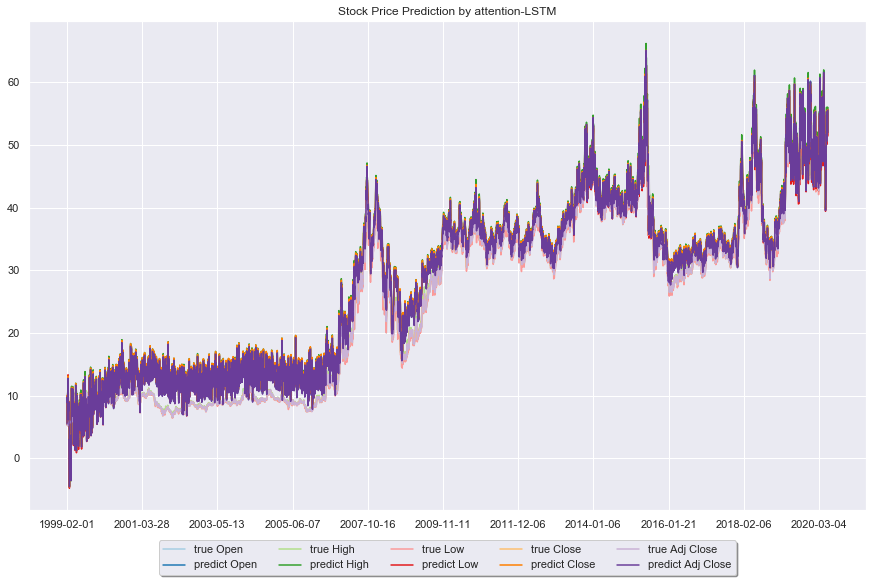

In [16]:
# for i in range(future_day - 1):
#     date_ori.append(date_ori[-1] + timedelta(days = 1))

current_palette = sns.color_palette('Paired', 12)
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
x_range_original = np.arange(df.shape[0])
x_range_future = np.arange(df_log.shape[0])

ax.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
ax.plot(
    x_range_future,
    df_log[:, 0],
    label = 'predict Open',
    color = current_palette[1],
)
ax.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
ax.plot(
    x_range_future,
    df_log[:, 1],
    label = 'predict High',
    color = current_palette[3],
)
ax.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
ax.plot(
    x_range_future,
    df_log[:, 2],
    label = 'predict Low',
    color = current_palette[5],
)
ax.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
ax.plot(
    x_range_future,
    df_log[:, 3],
    label = 'predict Close',
    color = current_palette[7],
)
ax.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
ax.plot(
    x_range_future,
    df_log[:, 4],
    label = 'predict Adj Close',
    color = current_palette[9],
)

box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.title('Stock Price Prediction by attention-LSTM')
plt.xticks(x_range_future[::500], date_ori[::500])
plt.show()

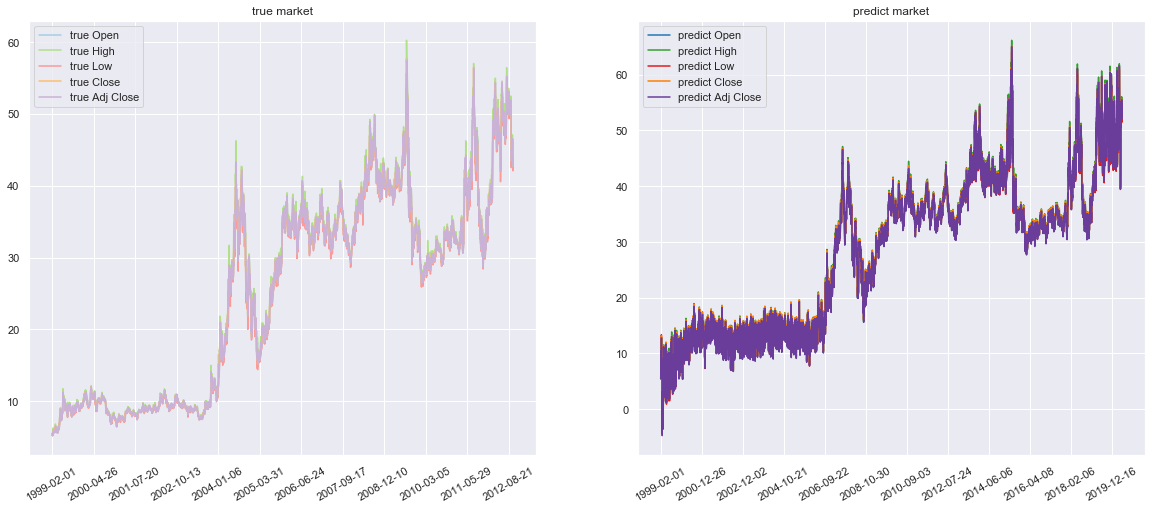

In [28]:
fig = plt.figure(figsize = (20, 8))
plt.subplot(1, 2, 1)
plt.plot(
    x_range_original,
    df.iloc[:, 1],
    label = 'true Open',
    color = current_palette[0],
)
plt.plot(
    x_range_original,
    df.iloc[:, 2],
    label = 'true High',
    color = current_palette[2],
)
plt.plot(
    x_range_original,
    df.iloc[:, 3],
    label = 'true Low',
    color = current_palette[4],
)
plt.plot(
    x_range_original,
    df.iloc[:, 4],
    label = 'true Close',
    color = current_palette[6],
)
plt.plot(
    x_range_original,
    df.iloc[:, 5],
    label = 'true Adj Close',
    color = current_palette[8],
)
plt.xticks(x_range_original[::450], history_date[::450],rotation=30)
plt.legend()
plt.title('true market')
plt.subplot(1, 2, 2)
plt.plot(
    x_range_future,
    df_log[:, 0],
    label = 'predict Open',
    color = current_palette[1],
)
plt.plot(
    x_range_future,
    df_log[:, 1],
    label = 'predict High',
    color = current_palette[3],
)
plt.plot(
    x_range_future,
    df_log[:, 2],
    label = 'predict Low',
    color = current_palette[5],
)
plt.plot(
    x_range_future,
    df_log[:, 3],
    label = 'predict Close',
    color = current_palette[7],
)
plt.plot(
    x_range_future,
    df_log[:, 4],
    label = 'predict Adj Close',
    color = current_palette[9],
)
plt.xticks(x_range_future[::450], date_ori[::450],rotation=30)
plt.legend()
plt.title('predict market')
plt.show()

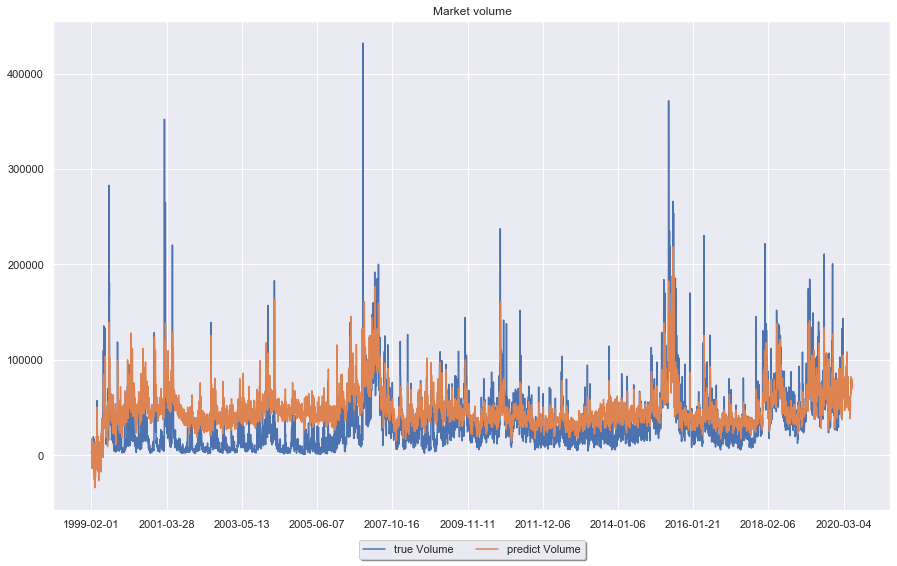

In [19]:
fig = plt.figure(figsize = (15, 10))
ax = plt.subplot(111)
ax.plot(x_range_original, df.iloc[:, -1], label = 'true Volume')
ax.plot(x_range_future, df_log[:, -1], label = 'predict Volume')
box = ax.get_position()
ax.set_position(
    [box.x0, box.y0 + box.height * 0.1, box.width, box.height * 0.9]
)
ax.legend(
    loc = 'upper center',
    bbox_to_anchor = (0.5, -0.05),
    fancybox = True,
    shadow = True,
    ncol = 5,
)
plt.xticks(x_range_future[::500], date_ori[::500])
plt.title('Market volume')
plt.show()